# Scraping Melting Points using PUG View (xml)

In [1]:
import requests
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

In [106]:
# load aqsoldb cids
cids = pd.read_csv('aqsoldb_cids.csv', header=None)

In [107]:
cids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [11]:
# empty list to add values to
mps = []
urls = []
    
# function that looks for the tag that contains the mp value and adds it to the list

def get_data(url):    
    
    # gets requested webpage
    response = requests.get(url)     
    
    # if request is successful
    if response.status_code == 200:   
        
        # parse xml into BeautifulSoup object
        soup = BeautifulSoup(response.content, 'xml')
        
        # find the tag/child
        child = soup.find('Information')
        
        # while the tag can be found 
        while True:    
            try:
                # add values found at String tag
                mps.append(' '.join(child.find('String')))
                # add corresponding url so can be matched later
                urls.append(url)
                
            except:
                mps.append('NaN')
                urls.append(url)
            
            try:   
                # find next sibling of child, i.e. next information tag which may contain further values
                child = child.find_next_sibling('Information')
            
            except:
                break
    
    # if the request does not return anything then add NaN to list with its corresponding url
    else:       
        mps.append('NaN')
        urls.append(url)
    
# iterates through all the cids in the list and puts them through the above function       
for i in cids[0]:
    base_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/'   
    compound_url = base_url + str(i) + '/xml?heading=Melting+Point'
    get_data(compound_url)

In [14]:
# make dataframe made up of mps and urls lists
df = pd.DataFrame({'URL': urls, 'Melting Point': mps})

In [15]:
df

,URL,Melting Point
0,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,NaN
1,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,175.5 °C
2,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,NaN
3,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,"111 to 117 °F (NTP, 1992)"
4,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,47.5 °C
...,...,...
21180,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,161°C
21181,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,161 °C
21182,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,322°F
21183,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,322°F


In [16]:
df.to_csv('dirty_mp.csv', index=False)

### Cleaning dataset

In [70]:
df = pd.read_csv('dirty_mp.csv')

In [71]:
# NaN values correspond to where to melting points can be found so these rows can be removed
df.dropna(subset=['Melting Point'], inplace=True)

In [72]:
df.reset_index(drop=True, inplace=True)

In [73]:
df

,URL,Melting Point
0,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,175.5 °C
1,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,"111 to 117 °F (NTP, 1992)"
2,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,47.5 °C
3,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,-86.3 °C
4,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,-86.3 °C
...,...,...
10455,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,161 °C
10456,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,161°C
10457,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,161 °C
10458,https://pubchem.ncbi.nlm.nih.gov/rest/pug_view...,322°F


In [74]:
# extract CID from url
df['URL'] = [x.replace('https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/', '') for x in df['URL']]
df['URL'] = [x.replace('/xml?heading=Melting+Point', '') for x in df['URL']]

In [75]:
df.rename(columns={'URL': 'CID'}, inplace=True)

In [76]:
df

,CID,Melting Point
0,67222,175.5 °C
1,7726,"111 to 117 °F (NTP, 1992)"
2,7726,47.5 °C
3,7529,-86.3 °C
4,7529,-86.3 °C
...,...,...
10455,54678486,161 °C
10456,54678486,161°C
10457,54678486,161 °C
10458,54678486,322°F


In [77]:
# drop duplicate values
df.drop_duplicates(inplace=True)

In [78]:
df

,CID,Melting Point
0,67222,175.5 °C
1,7726,"111 to 117 °F (NTP, 1992)"
2,7726,47.5 °C
3,7529,-86.3 °C
5,20849290,-35 - +2 °C
...,...,...
10453,54678486,"322 °F (EPA, 1998)"
10454,54678486,161.0 °C
10455,54678486,161 °C
10456,54678486,161°C


In [79]:
df.to_csv('melting_point_data.csv', index=False)

#### Separating Celsius measurements

In [80]:
df_celsius = df[df['Melting Point'].str.contains('°C')]

In [81]:
df_celsius.reset_index(drop=True, inplace=True)

In [82]:
df_celsius

,CID,Melting Point
0,67222,175.5 °C
1,7726,47.5 °C
2,7529,-86.3 °C
3,20849290,-35 - +2 °C
4,9582,103.5 °C
...,...,...
7298,6989,51.5°C
7299,2520,<25°C
7300,54678486,161.0 °C
7301,54678486,161 °C


In [83]:
# remove celsius sign so can format values as floats
df_celsius['Melting Point'] = [x.replace('°C', '') for x in df_celsius['Melting Point']]

<ipython-input-83-38d86701e8ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_celsius['Melting Point'] = [x.replace('°C', '') for x in df_celsius['Melting Point']]


In [84]:
df_celsius

,CID,Melting Point
0,67222,175.5
1,7726,47.5
2,7529,-86.3
3,20849290,-35 - +2
4,9582,103.5
...,...,...
7298,6989,51.5
7299,2520,<25
7300,54678486,161.0
7301,54678486,161


In [85]:
# convert melting point values to floats - any value that contains special characters such as <, >, +, - is taken as not exact and so can be excluded
df_celsius['Melting Point'] = df_celsius['Melting Point'].apply(pd.to_numeric, errors='coerce')

<ipython-input-85-6d93e27fbae1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_celsius['Melting Point'] = df_celsius['Melting Point'].apply(pd.to_numeric, errors='coerce')


In [86]:
df_celsius

,CID,Melting Point
0,67222,175.5
1,7726,47.5
2,7529,-86.3
3,20849290,NaN
4,9582,103.5
...,...,...
7298,6989,51.5
7299,2520,NaN
7300,54678486,161.0
7301,54678486,161.0


In [87]:
df_celsius.dropna(subset=['Melting Point'], inplace=True)

<ipython-input-87-ab178f72f133>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_celsius.dropna(subset=['Melting Point'], inplace=True)


In [88]:
df_celsius.reset_index(drop=True, inplace=True)

In [89]:
df_celsius

,CID,Melting Point
0,67222,175.5
1,7726,47.5
2,7529,-86.3
3,9582,103.5
4,7479,74.5
...,...,...
5657,6989,49.6
5658,6989,51.5
5659,54678486,161.0
5660,54678486,161.0


In [90]:
# now values are formatted the same can do another duplicate drop
df_celsius.drop_duplicates(inplace=True)

<ipython-input-90-0c708f743a95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_celsius.drop_duplicates(inplace=True)


In [91]:
df_celsius.reset_index(drop=True, inplace=True)

In [92]:
df_celsius

,CID,Melting Point
0,67222,175.5
1,7726,47.5
2,7529,-86.3
3,9582,103.5
4,7479,74.5
...,...,...
4657,5327,198.5
4658,1548885,183.0
4659,6989,51.5
4660,6989,49.6


In [93]:
# if the CID has returned more than one melting point value, then we will just take the top one
df_celsius.drop_duplicates(subset=['CID'], inplace=True)

<ipython-input-93-ad0ae2b883cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_celsius.drop_duplicates(subset=['CID'], inplace=True)


In [94]:
df_celsius

,CID,Melting Point
0,67222,175.5
1,7726,47.5
2,7529,-86.3
3,9582,103.5
4,7479,74.5
...,...,...
4656,3001055,69.5
4657,5327,198.5
4658,1548885,183.0
4659,6989,51.5


In [95]:
df_celsius.reset_index(drop=True, inplace=True)

In [96]:
df_celsius

,CID,Melting Point
0,67222,175.5
1,7726,47.5
2,7529,-86.3
3,9582,103.5
4,7479,74.5
...,...,...
3566,3001055,69.5
3567,5327,198.5
3568,1548885,183.0
3569,6989,51.5


In [97]:
df_celsius.to_csv('mp_celsius.csv', index=False)

### Adding InChIKeys back

In [98]:
df_celsius = pd.read_csv('mp_celsius.csv')

In [99]:
# loading csv with all identifiers for aqsoldb
db = pd.read_csv('PubChem_aqsoldb.csv')

In [100]:
# adding InChIKey where CIDs match up
df_celsius = df_celsius.assign(InChIKey=df_celsius['CID'].map(db.set_index('cid')['inchikey']))

In [101]:
df_celsius

,CID,Melting Point,InChIKey
0,67222,175.5,GPYLCFQEKPUWLD-UHFFFAOYSA-N
1,7726,47.5,AVPYQKSLYISFPO-UHFFFAOYSA-N
2,7529,-86.3,JZHGRUMIRATHIU-UHFFFAOYSA-N
3,9582,103.5,LSQARZALBDFYQZ-UHFFFAOYSA-N
4,7479,74.5,BGNGWHSBYQYVRX-UHFFFAOYSA-N
...,...,...,...
3566,3001055,69.5,VMXUWOKSQNHOCA-UKTHLTGXSA-N
3567,5327,198.5,ASWVTGNCAZCNNR-UHFFFAOYSA-N
3568,1548885,183.0,MLKXDPUZXIRXEP-RQZCQDPDSA-N
3569,6989,51.5,MGSRCZKZVOBKFT-UHFFFAOYSA-N


In [102]:
df_celsius.to_csv('mp_celsius.csv', index=False)

### Visualising Melting Point Data

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

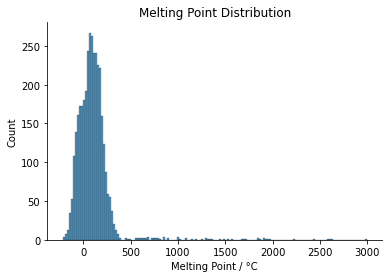

In [104]:
sns.histplot(data=df_celsius, x='Melting Point').set(title='Melting Point Distribution', xlabel='Melting Point / °C')
sns.despine()
plt.savefig('mp_distribution.jpg', bbox_inches='tight', dpi=300)

In [105]:
df_celsius['Melting Point'].describe()

count    3571.000000
mean       97.134309
std       204.943719
min      -218.400000
25%        -3.725000
50%        80.500000
75%       158.750000
max      2996.000000
Name: Melting Point, dtype: float64